In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import geopandas as gpd
from shapely.geometry import Point, Polygon, box
from geopy.distance import distance
from geopy.distance import geodesic


import seaborn as sns
import utils
import population_utils
import airport_utils
import demand_utils

/tmp/ipykernel_775482/2245578776.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
RAW_DIR = "./data/raw"
DERIVED_DIR = "./data/derived"
ONTIME_DIR = os.path.join(RAW_DIR, 'ontime')
DB1B_DIR = os.path.join(RAW_DIR, 'DB1B')

In [3]:
'''
collection of parameters that generates the Supply and Demand
'''

cluster_distance = 50  # DBSCAN parameter to cluster airports (unit: km)

population_exponent1 = 1.
population_exponent2 = 1.
decay_parameter = 2.0  # decay exponent of the gravity model
distance_threshold = 300  # minimum distance that the OD demand can be defined by using the gravity model (unit: km)

delta_min = 30  # minimum connect time w.o. sharing (unit: minute)
delta_share_min = 60  # minimum connect time w. sharing (unit: minute)
share = False  # flight share/non-share

# prepare raw data

In [ ]:
'''
ontime data
'''

YEAR = 2023
MONTH = 4
CARRIER = "all"
DATE = [18]

ontime_df = utils.prepare_ontime_df(year=YEAR, 
                                    month=MONTH, 
                                    carrier=CARRIER, 
                                    date=DATE, 
                                    distance_function="geodesic", 
                                    arrival_time="elapsed_time", 
                                    contiguous_us=True)  # import flight schedules
print(f"Number of flights within contiguous US territory: {len(ontime_df)}")
ontime_df.to_csv('./data/derived/filtered_list_of_flights.csv', index=False)

/home/mk139/WorkSpace/airline-spp-application/share/utils.py:146: DtypeWarning: Columns (11,13,86,93) have mixed types. Specify dtype option on import or set low_memory=False.
  ontime_df = pd.read_csv(os.path.join(ONTIME_DIR, f"On_Time_Marketing_Carrier_{year}_{month}.csv"))


total number of flights in 2023-4: 596676

total number of flights opereated by all on 2023-4-[18]: 19458



100%|██████████| 19458/19458 [00:09<00:00, 2039.86it/s]


total number of flights after adding time/distance information: 19458



/home/mk139/WorkSpace/airline-spp-application/share/utils.py:121: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  master_df = pd.read_csv(f'../data/raw/aircraft/master_{year}.txt', sep=',')


number of flights with nan values: 98

number of nan values from missing tail number: 8

Number of flights within contiguous US territory: 18598


In [7]:
ontime_df

,flight_idx,Origin,Dest,Operating_Airline,Tail_Number,CRSDepTime,CRSArrTime,CRSElapsedTime,UTCDepTime,UTCArrTime,Distance,NO_SEATS
0,1,DCA,SEA,AS,N590AS,2023-04-18 08:00:00,2023-04-18 10:49:00,349.0,1.681819e+09,1.681840e+09,3747.303757,149.0
1,2,SEA,DCA,AS,N568AS,2023-04-18 14:00:00,2023-04-18 21:59:00,299.0,1.681852e+09,1.681870e+09,3747.303757,149.0
2,3,DCA,SEA,AS,N508AS,2023-04-18 17:35:00,2023-04-18 20:24:00,349.0,1.681854e+09,1.681875e+09,3747.303757,149.0
3,4,SEA,DCA,AS,N508AS,2023-04-18 08:25:00,2023-04-18 16:34:00,309.0,1.681832e+09,1.681850e+09,3747.303757,149.0
4,5,DCA,LAX,AS,N520AS,2023-04-18 09:10:00,2023-04-18 11:52:00,342.0,1.681823e+09,1.681844e+09,3719.085326,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...
18593,18594,BDL,CLT,OH,N567NN,2023-04-18 10:10:00,2023-04-18 12:16:00,126.0,1.681827e+09,1.681835e+09,1035.989568,95.0
18594,18595,CLT,BTR,OH,N607NN,2023-04-18 18:20:00,2023-04-18 19:36:00,136.0,1.681856e+09,1.681865e+09,1086.280033,95.0
18595,18596,DCA,CVG,OH,N582NN,2023-04-18 20:23:00,2023-04-18 22:14:00,111.0,1.681864e+09,1.681870e+09,661.595377,95.0
18596,18597,HPN,DCA,OH,N523AE,2023-04-18 06:30:00,2023-04-18 07:48:00,78.0,1.681814e+09,1.681818e+09,376.034307,80.0


In [6]:
'''
DB1B data (supplied itineraries)
'''
# outlier_of_us = utils.get_outlier_airports()  # airports outside of the contiguous US territory
# available_airports = ontime_df[['Origin', 'Dest']].values.flatten()
db1b_file = f'DB1B_Coupon_{YEAR}_Q{int(MONTH / 12 * 4)+1}.csv'
db1b_file = os.path.join(DB1B_DIR, db1b_file)
db1b_df = pd.read_csv(db1b_file)
# mask = ~db1b_df['Origin'].isin(outlier_of_us) & ~db1b_df['Dest'].isin(outlier_of_us)
# db1b_df = db1b_df[mask]
# print(f"Number of flights within contiguous US territory: {len(db1b_df)}")
# mask = db1b_df['Origin'].isin(available_airports) & db1b_df['Dest'].isin(available_airports)
# db1b_df = db1b_df[mask]
# print(f"Number of flights within available airports: {len(db1b_df)}")


/home/mk139/WorkSpace/airline-spp-application/share/population_utils.py:36: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/nobackup/mk139/anaconda3/envs/airline-spp-application/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


"\nYou might see blurry population density map. \nThis is because the ``geometry'' column is defined as the ``geometry_center'' column.\n\nTo fix this, \n    i) you can use the following code:\n    population_gdf.set_geometry('geometry_boundary', inplace=True, crs=population_gdf.crs)\n\nor\n\n    ii) you can change the size of the points in the plot (e.g., set s=1)\n\n    \nBy default, crs is set to EPSG:4326, \nwhich represents locations on the Earth using latitude and longitude coordinates in degrees.\n"

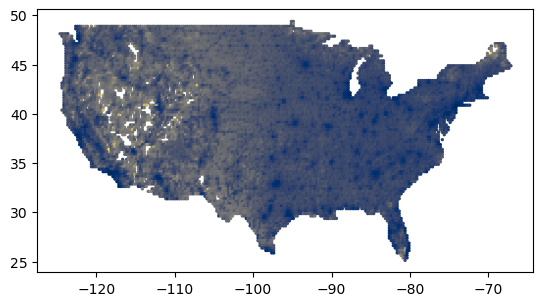

In [7]:
'''
population data
'''
us_bbox = (-130., 23., -65., 50)  # bbox of contiguous us territory
population_path = "./data/raw/other/gpw-v4-population-density-adjusted-to-2015-unwpp-country-totals-rev11_2020_15_min_asc"
population_file = "gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_15_min.asc"


population_gdf = population_utils.retrieve_us_population_gdf(
    os.path.join(population_path, population_file), 
    log_population=True,
    contiguous_us=True,
    post_process=True,
    )

population_gdf.plot(column='log10_population_density', cmap='cividis_r', s=2)
population_gdf.to_csv('./data/derived/population.csv', index=False)



"""
You might see blurry population density map. 
This is because the ``geometry'' column is defined as the ``geometry_center'' column.

To fix this, 
    i) you can use the following code:
    population_gdf.set_geometry('geometry_boundary', inplace=True, crs=population_gdf.crs)

or

    ii) you can change the size of the points in the plot (e.g., set s=1)

    
By default, crs is set to EPSG:4326, 
which represents locations on the Earth using latitude and longitude coordinates in degrees.
"""


# Cluster Airports

In [8]:
operating_coords = airport_utils.get_operating_airport_coords(ontime_df)
super_airport_dict = airport_utils.cluster_airports(cluster_distance, operating_coords)
airport_to_super_airport_mapper = airport_utils.get_airport_to_super_airport_mapper(super_airport_dict) 
super_airport_centroids = airport_utils.get_super_airport_centroids(super_airport_dict, operating_coords)
super_airport_gdf = airport_utils.get_super_airport_gdf(super_airport_centroids)

In [9]:
'''
just to chek what super airports I have,
and to see if there's any ill-defined flights within super airports
'''

airport_utils.show_super_airports(super_airport_dict)
airport_utils.show_flights_within_super_airports(super_airport_dict, ontime_df)

['ASE', 'EGE']
['ATW', 'GRB']
['BRO', 'HRL']
['BUR', 'LAX', 'LGB', 'ONT', 'SNA']
['BWI', 'DCA', 'IAD']
['DAL', 'DFW']
['EWR', 'HPN', 'JFK', 'LGA']
['FLL', 'MIA']
['HHH', 'SAV']
['HOU', 'IAH']
['JST', 'LBE']
['LWS', 'PUW']
['MDW', 'ORD']
['OAK', 'SFO', 'SJC']
['ORF', 'PHF']
there is no flight within the same super airport


In [10]:
super_airport_gdf

,super_airport_id,geometry
0,1,POINT (-75.44080 40.65210)
1,2,POINT (-99.68190 32.41130)
2,3,POINT (-106.60900 35.04020)
3,4,POINT (-98.42180 45.44910)
4,5,POINT (-84.19450 31.53550)
...,...,...
275,276,POINT (-86.52540 30.48320)
276,277,POINT (-94.30680 36.28190)
277,278,POINT (-103.74170 48.25780)
278,279,POINT (-120.54400 46.56820)


In [11]:
pickle.dump(super_airport_centroids, open('./data/derived/super_airport_centroids.pkl', 'wb'))

In [12]:
airport_to_super_airport_mapper

{'ABE': 1,
 'ABI': 2,
 'ABQ': 3,
 'ABR': 4,
 'ABY': 5,
 'ACT': 6,
 'ACV': 7,
 'ACY': 8,
 'AEX': 9,
 'AGS': 10,
 'ALB': 11,
 'ALO': 12,
 'ALW': 13,
 'AMA': 14,
 'ANC': 15,
 'APN': 16,
 'ART': 17,
 'ASE': 18,
 'EGE': 18,
 'ATL': 19,
 'ATW': 20,
 'GRB': 20,
 'AUS': 21,
 'AVL': 22,
 'AVP': 23,
 'AZO': 24,
 'BDL': 25,
 'BFF': 26,
 'BFL': 27,
 'BGM': 28,
 'BGR': 29,
 'BHM': 30,
 'BIL': 31,
 'BIS': 32,
 'BJI': 33,
 'BLI': 34,
 'BMI': 35,
 'BNA': 36,
 'BOI': 37,
 'BOS': 38,
 'BPT': 39,
 'BQK': 40,
 'BRD': 41,
 'BRO': 42,
 'HRL': 42,
 'BTM': 43,
 'BTR': 44,
 'BTV': 45,
 'BUF': 46,
 'BUR': 47,
 'LAX': 47,
 'LGB': 47,
 'ONT': 47,
 'SNA': 47,
 'BWI': 48,
 'DCA': 48,
 'IAD': 48,
 'BZN': 49,
 'CAE': 50,
 'CAK': 51,
 'CDC': 52,
 'CHA': 53,
 'CHO': 54,
 'CHS': 55,
 'CID': 56,
 'CIU': 57,
 'CLE': 58,
 'CLL': 59,
 'CLT': 60,
 'CMH': 61,
 'CMI': 62,
 'CMX': 63,
 'CNY': 64,
 'COD': 65,
 'COS': 66,
 'COU': 67,
 'CPR': 68,
 'CRP': 69,
 'CRW': 70,
 'CSG': 71,
 'CVG': 72,
 'CWA': 73,
 'DAB': 74,
 'DAL': 75,
 

# Generate Gravity Model Demand

In [13]:
distance_df = airport_utils.get_pairwise_distance_df(super_airport_gdf, duplicate=True)
distance_df

100%|██████████| 39060/39060 [00:10<00:00, 3662.23it/s]

Shortest distance pairs between super airports:
       super_airport_1  super_airport_2  distance_km
7296                28              143    50.382487
46356              143               28    50.382487




,super_airport_1,super_airport_2,distance_km
0,1,2,2345.709228
1,1,3,2797.453734
2,1,4,1939.137967
3,1,5,1280.996006
4,1,6,2194.602320
...,...,...,...
78115,279,277,2456.628897
78116,280,277,1904.014387
78117,279,278,1279.221535
78118,280,278,1957.716200


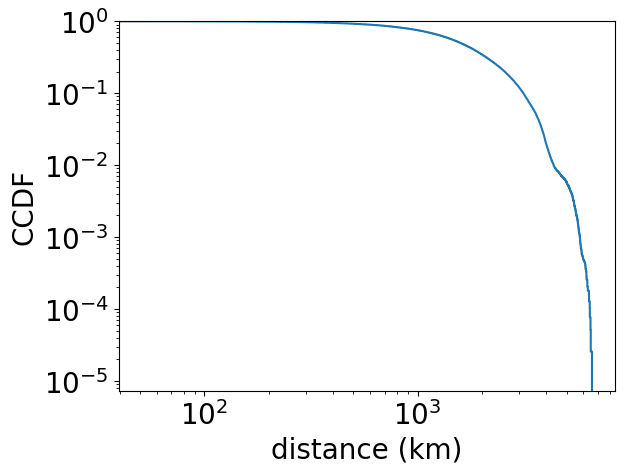

In [14]:
fig, ax = plt.subplots()
sns.ecdfplot(data=distance_df['distance_km'], complementary=True, ax=ax, label=' ')

ax.set_xlabel('distance (km)', fontsize=20)
ax.set_ylabel('CCDF', fontsize=20)
ax.tick_params('both', labelsize=20)
ax.loglog()

plt.show()

In [15]:
population_mapper = airport_utils.assign_population_to_super_airports(super_airport_gdf, 
                                                                      population_gdf, 
                                                                      method="nearest", 
                                                                      radius_km=None, 
                                                                      fillin="median")

100%|██████████| 13008/13008 [00:02<00:00, 5703.50it/s]


In [16]:
population_mapper

{1: 2841.043170928955,
 2: 465.48218616470695,
 3: 1753.0354188357014,
 4: 263.6876117810607,
 5: 973.1520292758942,
 6: 710.3385813236237,
 7: 421.7939736917615,
 8: 976.4087791442871,
 9: 570.5953673124313,
 10: 1552.6708785295486,
 11: 2582.91518381238,
 12: 516.3604869842529,
 13: 239.69705389806768,
 14: 677.1826115180738,
 15: 1082.9906442128122,
 16: 285.10280907154083,
 17: 549.6109913885593,
 18: 311.5357282757759,
 19: 11781.675666809082,
 20: 2868.215577363968,
 21: 3360.52996301651,
 22: 1289.3374137878418,
 23: 1512.0373320579529,
 24: 1115.5111351013184,
 25: 5207.089839935303,
 26: 232.0742720477283,
 27: 1842.285455860026,
 28: 699.1834297180176,
 29: 983.0214495416297,
 30: 2589.4222314357758,
 31: 394.76241905684583,
 32: 295.6827305108309,
 33: 313.63507049530745,
 34: 907.4031299195485,
 35: 538.9371123313904,
 36: 4775.7581334114075,
 37: 1648.3999581017779,
 38: 9025.543014526367,
 39: 846.4320693463087,
 40: 517.4082322120667,
 41: 1115.3290646076202,
 42: 1619.1

In [17]:
import pickle

pickle.dump(population_mapper, open('./data/derived/new_population_mapper.pkl', 'wb'))

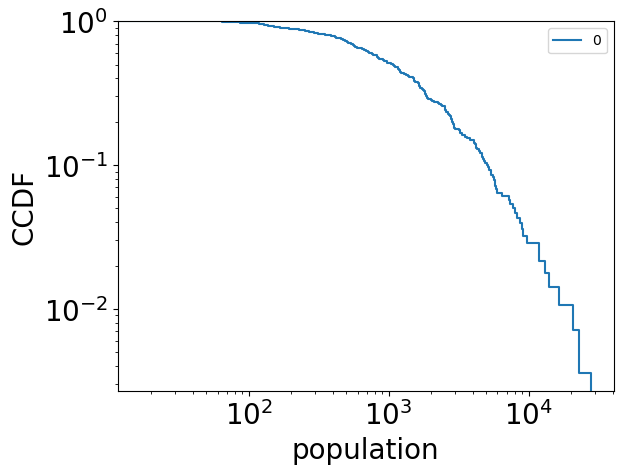

In [18]:
fig, ax = plt.subplots()
sns.ecdfplot(data=population_mapper.values(), complementary=True, ax=ax, label=' ')

ax.set_xlabel('population', fontsize=20)
ax.set_ylabel('CCDF', fontsize=20)
ax.tick_params('both', labelsize=20)
ax.loglog()

plt.show()

In [19]:
gravity_demand = demand_utils.make_gravity_model_demand(distance_df, 
                                                        population_mapper, 
                                                        minimum_distance_km=distance_threshold, 
                                                        population_exponent1=population_exponent1, 
                                                        population_exponent2=population_exponent2, 
                                                        decay_function="power", 
                                                        decay_parameter=decay_parameter,
                                                        normalize_demand=False)

gravity_demand

,super_airport_1,super_airport_2,distance_km,population1,population2,demand
0,1,2,2345.709228,2841.043171,465.482186,0.240344
1,1,3,2797.453734,2841.043171,1753.035419,0.636418
2,1,4,1939.137967,2841.043171,263.687612,0.199228
3,1,5,1280.996006,2841.043171,973.152029,1.684857
4,1,6,2194.602320,2841.043171,710.338581,0.419017
...,...,...,...,...,...,...
78115,279,277,2456.628897,601.305999,1189.334623,0.118501
78116,280,277,1904.014387,694.099045,1189.334623,0.227712
78117,279,278,1279.221535,601.305999,152.968031,0.056209
78118,280,278,1957.716200,694.099045,152.968031,0.027703


In [21]:
gravity_demand[(gravity_demand['super_airport_1']==141) & (gravity_demand['super_airport_2']==225)]

,super_airport_1,super_airport_2,distance_km,population1,population2,demand
29413,141,225,1317.178488,16.831578,85.809747,0


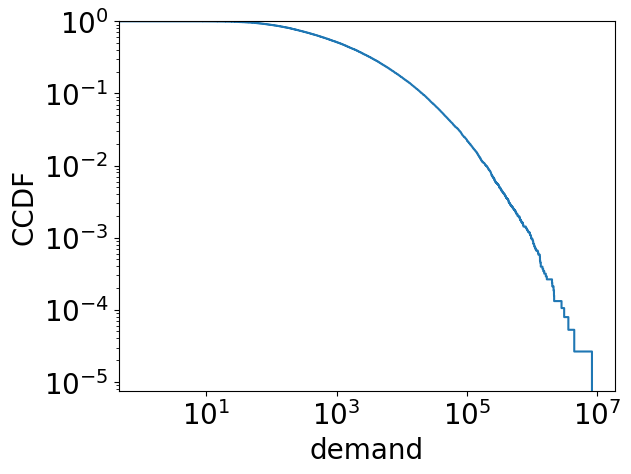

In [19]:
fig, ax = plt.subplots()
sns.ecdfplot(data=gravity_demand['demand'], complementary=True, ax=ax, label=' ')

ax.set_xlabel('demand', fontsize=20)
ax.set_ylabel('CCDF', fontsize=20)
ax.tick_params('both', labelsize=20)
ax.loglog()

plt.show()

In [20]:
OD_demand = demand_utils.create_OD_matrix_from_itineraries(db1b_df, airport_to_super_airport_mapper)
OD_demand

collecting and sorting directional markets



100%|██████████| 11270029/11270029 [00:52<00:00, 215414.11it/s]


creating OD matrix from sorted directional markets



100%|██████████| 7616858/7616858 [00:14<00:00, 510657.34it/s]


these self-loops are discarded from the OD matrix: {}


{('GRR', 'BHM'): 125,
 ('SDF', 'TPA'): 2259,
 ('FLL', 'SEA'): 3332,
 ('CVG', 'MIA'): 1984,
 ('TUL', 'SAT'): 495,
 ('SDF', 'PHL'): 810,
 ('AGS', 'DCA'): 410,
 ('TLH', 'DCA'): 504,
 ('TVC', 'BDL'): 36,
 ('LAX', 'OKC'): 1282,
 ('ORD', 'SNA'): 6046,
 ('IAD', 'SFO'): 10093,
 ('ORD', 'SFO'): 15234,
 ('MCO', 'SFO'): 6199,
 ('BOS', 'SFO'): 16518,
 ('CMH', 'SBA'): 75,
 ('ATL', 'DEN'): 11685,
 ('SBA', 'CMH'): 73,
 ('SFO', 'IAD'): 10085,
 ('DEN', 'IAD'): 6438,
 ('BNA', 'EUG'): 229,
 ('SFO', 'EWR'): 18836,
 ('DEN', 'RDU'): 4895,
 ('DEN', 'BWI'): 6333,
 ('SAT', 'EWR'): 2264,
 ('PBI', 'EWR'): 10208,
 ('SAN', 'EWR'): 6104,
 ('EWR', 'TUS'): 394,
 ('ORD', 'LGA'): 25113,
 ('IAH', 'LGA'): 10361,
 ('IAH', 'ORD'): 10211,
 ('LAS', 'ORD'): 13632,
 ('ORD', 'MSO'): 312,
 ('DEN', 'PIT'): 3130,
 ('IAD', 'SAN'): 3772,
 ('ORD', 'LAX'): 20715,
 ('LAX', 'BZN'): 940,
 ('MSY', 'SFO'): 2722,
 ('DEN', 'MSY'): 4646,
 ('BOS', 'IAH'): 5780,
 ('PHL', 'IAH'): 5325,
 ('SAN', 'IAH'): 3270,
 ('LAS', 'IAH'): 10059,
 ('ANC', 'MIA

In [21]:
uniform_demand = demand_utils.create_uniform_OD_matrix(db1b_df)
uniform_demand

AttributeError: module 'demand_utils' has no attribute 'create_uniform_OD_matrix'

NameError: name 'uniform_demand' is not defined

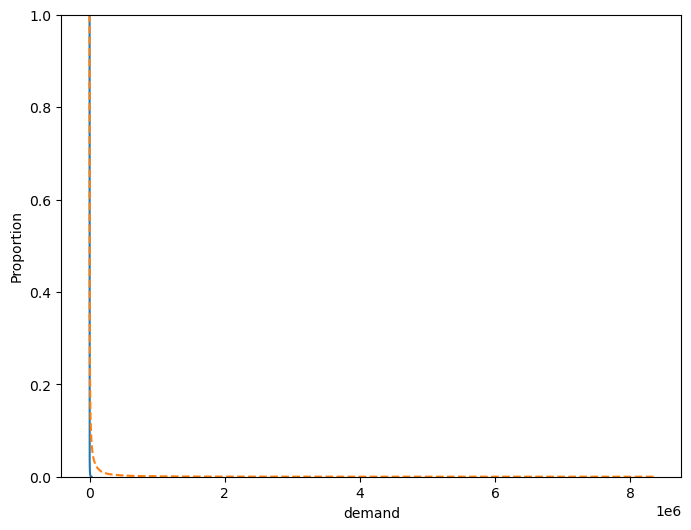

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.ecdfplot(data=list(OD_demand.values()), complementary=True, label="DB1B data")
sns.ecdfplot(data=gravity_demand['demand'], complementary=True,ls='--', label='gravity model')
sns.ecdfplot(data=uniform_demand.values(), complementary=True, ls=':', label='uniform demand')  

ax.tick_params('both', labelsize=20)
ax.set_xlabel('demand count', fontsize=20)
ax.set_ylabel('CCDF', fontsize=20)
ax.legend(fontsize=20)

ax.set_ylim(10**-5, 2.)

ax.loglog()
plt.tight_layout()
# plt.savefig(f'../results/figs/quals/gravity_model_ccdf.pdf', format='pdf')

plt.show()

# now let's make the actual files!

In [23]:
share=True
flights, origin_airport, destination_airport = utils.group_flights_origin_destination(ontime_df)
fcn = utils.create_flight_connection_network(flights, origin_airport, delta_min, delta_share_min, share)

fname = f'./data/derived/fcn_Y{YEAR}_M{MONTH}_D{DATE[0]}'
utils.write_flight_connection_network_to_file(fname, fcn, share)


share=False
flights, origin_airport, destination_airport = utils.group_flights_origin_destination(ontime_df)
fcn = utils.create_flight_connection_network(flights, origin_airport, delta_min, delta_share_min, share)

fname = f'./data/derived/fcn_Y{YEAR}_M{MONTH}_D{DATE[0]}'
utils.write_flight_connection_network_to_file(fname, fcn, share)

# When relying on the converted departure time: # 874432 # 2782725  
# When relying on the elapsed time: # 819918 # 2586839

# When relying on the ellapsed time & changing >= to >:
# 816432 # 2575627


100%|██████████| 18598/18598 [00:03<00:00, 4901.66it/s]


# of total edges in FCN : 2575627


100%|██████████| 18598/18598 [00:03<00:00, 5681.59it/s]


# of total edges in FCN : 816432


In [24]:
flights

{1: {'origin': 'DCA',
  'destination': 'SEA',
  'utc_departure': 1681819200.0,
  'utc_arrival': 1681840140.0,
  'elapsed_time': 349.0,
  'distance': 3747.3037574693353,
  'seats': 149.0,
  'carrier': 'AS',
  'tail_number': 'N590AS'},
 2: {'origin': 'SEA',
  'destination': 'DCA',
  'utc_departure': 1681851600.0,
  'utc_arrival': 1681869540.0,
  'elapsed_time': 299.0,
  'distance': 3747.3037574693353,
  'seats': 149.0,
  'carrier': 'AS',
  'tail_number': 'N568AS'},
 3: {'origin': 'DCA',
  'destination': 'SEA',
  'utc_departure': 1681853700.0,
  'utc_arrival': 1681874640.0,
  'elapsed_time': 349.0,
  'distance': 3747.3037574693353,
  'seats': 149.0,
  'carrier': 'AS',
  'tail_number': 'N508AS'},
 4: {'origin': 'SEA',
  'destination': 'DCA',
  'utc_departure': 1681831500.0,
  'utc_arrival': 1681850040.0,
  'elapsed_time': 309.0,
  'distance': 3747.3037574693353,
  'seats': 149.0,
  'carrier': 'AS',
  'tail_number': 'N508AS'},
 5: {'origin': 'DCA',
  'destination': 'LAX',
  'utc_departure':

In [25]:
super_flights_df = airport_utils.get_super_flight_df(flights, airport_to_super_airport_mapper, distance_df)
super_flights_df['origin'].unique()

array([ 48, 243,  47, 195, 203,  97, 234,  15, 240, 172, 206, 169,  75,
       104,  38,  85, 197,  21, 263,  58,  19, 180,  36, 190, 255,  55,
       196, 210, 132, 168, 205,  91,  61, 191, 235, 140,  72, 222, 227,
       152, 249,  79, 267,   3, 201,  37,  49, 221,  94, 113, 215, 251,
       216, 236, 100, 256, 279, 137, 238, 164,  31,  13, 176, 189,  87,
       102, 146,  25, 202, 261,  11, 232, 254, 224, 229,  46,  45, 128,
       217, 199,  60,  98, 116,  32,  42,  69,  27, 266,  83, 277, 154,
       270,  59, 260, 253, 103, 119, 115, 157, 158, 162, 183, 233, 280,
       153, 248, 252,  39, 159,  66,   6, 271, 237, 187, 110, 112, 160,
       230,   9, 108,  18, 120, 214, 245,  34, 130, 124, 220,  14,  99,
        20, 133, 167, 123,  22, 272,   7,  68,  23,  30,  50,  51,  81,
        56,  70, 174, 182, 106, 244, 219, 161, 278,  53,  82, 126,  84,
       136,  78, 147, 155,  63, 135, 250, 149,  77, 156,  86, 148, 107,
       170, 173, 111, 258, 151, 208,  64, 274,  26, 225, 226, 24

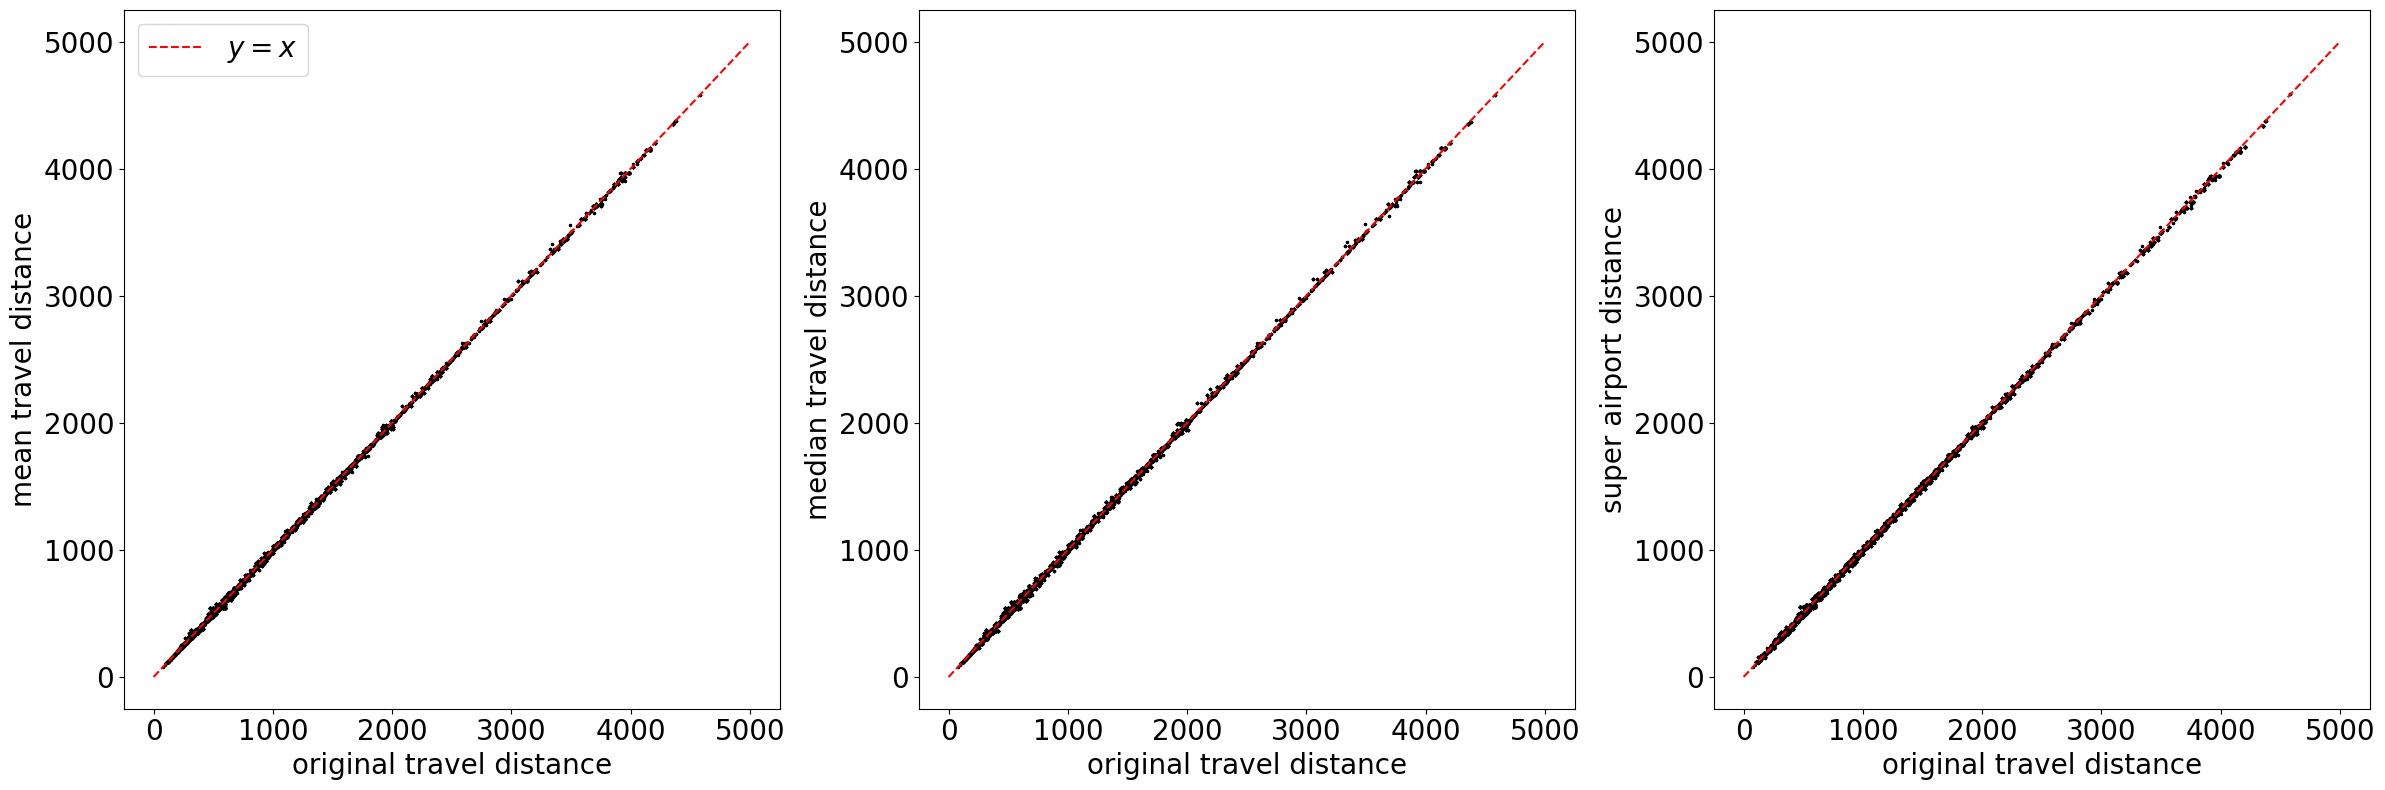

In [26]:
"""
these are just to validate if it is safe to rely on the 
original distance or if I need to use median / mean / or centroid distances instead.
"""

x_ = np.linspace(0, 5000)

fig, ax = plt.subplots(ncols=3, figsize=(24, 8))

ax[0].scatter(super_flights_df['distance'], super_flights_df['mean_distance'], s=2, c='k')
ax[1].scatter(super_flights_df['distance'], super_flights_df['median_distance'], s=2, c='k')
ax[2].scatter(super_flights_df['distance'], super_flights_df['centroid_distance'], s=2, c='k')

ax[0].plot(x_, x_, ls='--', c='r', label='$y=x$')
ax[1].plot(x_, x_, ls='--', c='r')
ax[2].plot(x_, x_, ls='--', c='r')


ax[0].set_xlabel('original travel distance', fontsize=20)
ax[0].set_ylabel('mean travel distance', fontsize=20)
ax[0].tick_params('both', labelsize=20)

ax[1].set_xlabel('original travel distance', fontsize=20)
ax[1].set_ylabel('median travel distance', fontsize=20)
ax[1].tick_params('both', labelsize=20)

ax[2].set_xlabel('original travel distance', fontsize=20)
ax[2].set_ylabel('super airport distance', fontsize=20)
ax[2].tick_params('both', labelsize=20)

ax[0].legend(fontsize=20, loc='upper left')

plt.tight_layout()
plt.show()

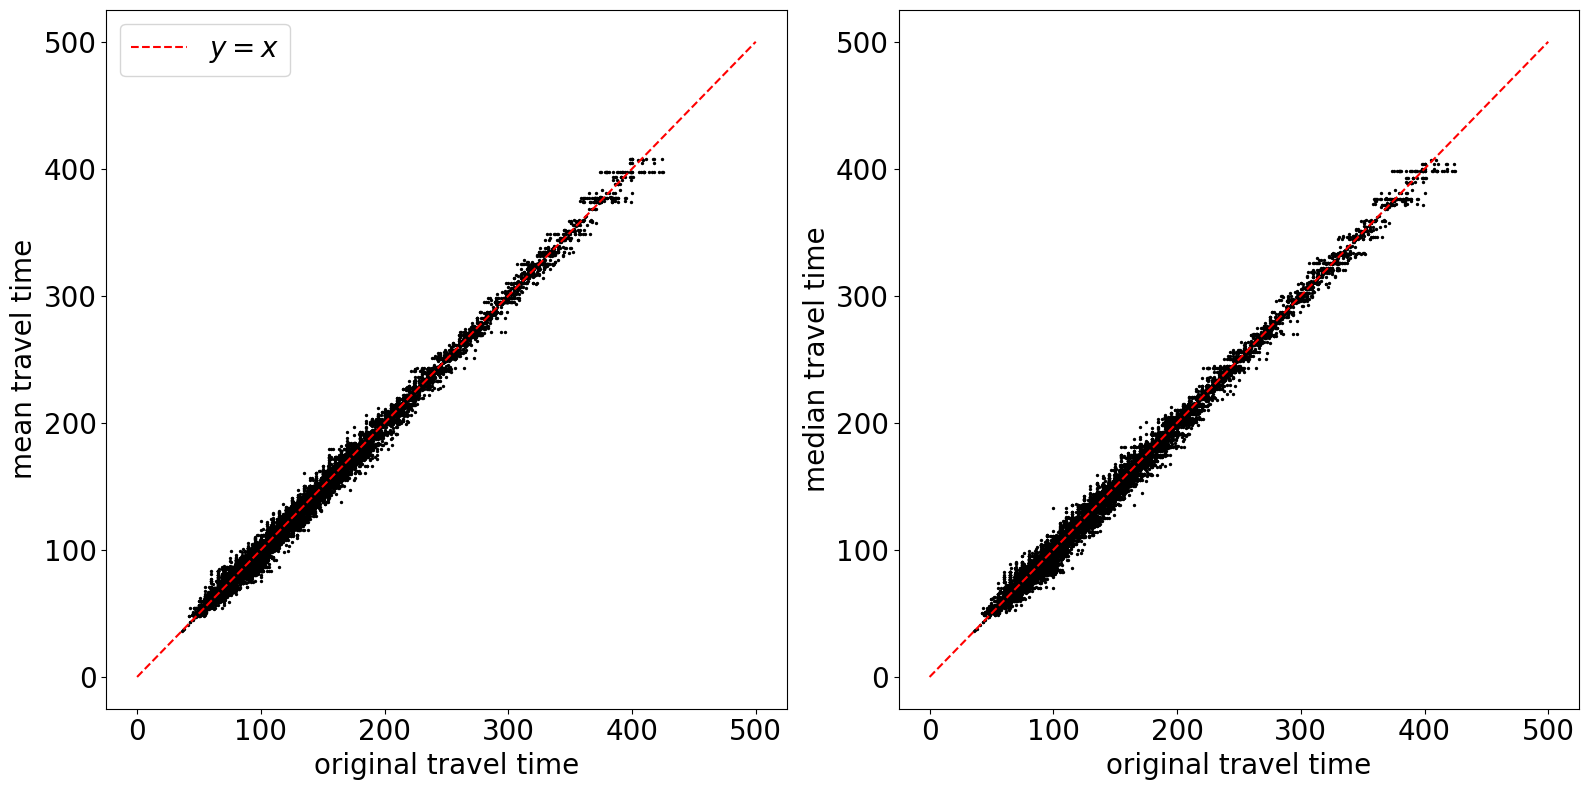

In [27]:
"""
same as above, but for elapsed time
"""

x_ = np.linspace(0, 500)

fig, ax = plt.subplots(ncols=2, figsize=(16, 8))

ax[0].scatter(super_flights_df['elapsed_time'], super_flights_df['mean_elapsed_time'], s=2, c='k')
ax[1].scatter(super_flights_df['elapsed_time'], super_flights_df['median_elapsed_time'], s=2, c='k')


ax[0].plot(x_, x_, ls='--', c='r', label='$y=x$')
ax[1].plot(x_, x_, ls='--', c='r')


ax[0].set_xlabel('original travel time', fontsize=20)
ax[0].set_ylabel('mean travel time', fontsize=20)
ax[0].tick_params('both', labelsize=20)

ax[1].set_xlabel('original travel time', fontsize=20)
ax[1].set_ylabel('median travel time', fontsize=20)
ax[1].tick_params('both', labelsize=20)


ax[0].legend(fontsize=20, loc='upper left')

plt.tight_layout()
plt.show()

In [28]:
'''
output files

flights -> list of flights and their details
super_flight_df -> list of flights with super-airport information

airport_to_super_airport_mapper -> airport: super-airport ID

FCN -> flight connection network

OD_demand -> OD demand from supplied itineraries
demand_df -> super airport OD demand from gravity model
'''

'\noutput files\n\nflights -> list of flights and their details\nsuper_flight_df -> list of flights with super-airport information\n\nairport_to_super_airport_mapper -> airport: super-airport ID\n\nFCN -> flight connection network\n\nOD_demand -> OD demand from supplied itineraries\ndemand_df -> super airport OD demand from gravity model\n'

In [29]:
airports = utils.get_airport_mapper(OD_demand)

fname = f'./data/derived/list_of_flights_Y{YEAR}_M{MONTH}_D{DATE[0]}.dat'
utils.write_list_of_flights_to_file(fname, flights, airport_to_super_airport_mapper)

fname = f'./data/derived/list_of_super_flights_Y{YEAR}_M{MONTH}_D{DATE[0]}.dat'
utils.write_list_of_super_flights_to_file(fname, super_flights_df)

fname = f'./data/derived/DB1B_demand_{YEAR}_Q{int(MONTH / 12 * 4)+1}.dat'
utils.write_supplied_demand_to_file(fname, OD_demand, airport_to_super_airport_mapper)

fname = f'./data/derived/gravity_demand_pop1_{population_exponent1}_pop2_{population_exponent2}_decay_{decay_parameter}_d_{distance_threshold}.dat'
utils.write_gravity_demand_to_file(fname, gravity_demand)

fname = f'./data/derived/super_airport_mapper_d{cluster_distance}.dat'
utils.write_super_airport_mapper_to_file(fname, airport_to_super_airport_mapper, if_pickle=False)

fname = f'./data/derived/super_airport_mapper_d{cluster_distance}.pkl'
utils.write_super_airport_mapper_to_file(fname, airport_to_super_airport_mapper, if_pickle=True)

fname = f'./data/derived/IATA_to_integer_mapper.dat'
utils.write_IATA_to_integer_mapper_to_file(fname, airports, if_pickle=False)

# fname = f'./data/derived/IATA_to_integer_mapper.pkl'
# utils.write_IATA_to_integer_mapper_to_file(fname, airports, if_pickle=True)


100%|██████████| 54130/54130 [00:00<00:00, 2062741.22it/s]


100%|██████████| 75754/75754 [00:03<00:00, 22139.51it/s]


In [ ]:
# # # import pickle

# # def write_super_airport_mapper_to_file(fname, airport_to_super_airport_mapper, if_pickle=False):
# #     if if_pickle:
# #         with open(fname, 'wb') as f:
# #             pickle.dump(airport_to_super_airport_mapper, f)
# #     else:
# #         with open(fname, 'w') as f:
# #             for iata_code, super_code in airport_to_super_airport_mapper.items():
# #                 tmp = str(iata_code) + ' ' + "SP" + str(super_code)
# #                 f.write(tmp + '\n')

# fname = f'./data/derived/super_airport_mapper_d{cluster_distance}.dat'
# write_super_airport_mapper_to_file(fname, airport_to_super_airport_mapper, if_pickle=False)

# fname = f'./data/derived/super_airport_mapper_d{cluster_distance}.pkl'
# write_super_airport_mapper_to_file(fname, airport_to_super_airport_mapper, if_pickle=True)


# # def write_IATA_to_integer_mapper_to_file(fname, airports, if_pickle=False):
# #     if if_pickle:
# #         with open(fname, 'wb') as f:
# #             pickle.dump(airports, f)
# #     else:
# #         with open(fname, 'w') as f:
# #             for iata_code, integer_code in airports.items():
# #                 tmp = str(iata_code) + ' ' + str(integer_code)
# #                 f.write(tmp + '\n')

# fname = f'./data/derived/IATA_to_integer_mapper.dat'
# write_IATA_to_integer_mapper_to_file(fname, airports, if_pickle=False)

# fname = f'./data/derived/IATA_to_integer_mapper.pkl'
# write_IATA_to_integer_mapper_to_file(fname, airports, if_pickle=True)


In [31]:
# for iata_code, integer_code in airports.items():
#     print(iata_code, integer_code)

In [32]:
# def aggregate_demand(OD_demand, mapper):
#     aggregated_OD_demand = {}
#     for (origin, destination) in tqdm(OD_demand):
#         if origin not in mapper:
#             continue
#         if destination not in mapper:
#             continue
#         if (mapper[origin], mapper[destination]) not in aggregated_OD_demand:
#             aggregated_OD_demand[(mapper[origin], mapper[destination])] = 0
#         aggregated_OD_demand[(mapper[origin], mapper[destination])] += OD_demand[(origin, destination)]
#     return aggregated_OD_demand

# aggregated_OD_demand = aggregate_demand(OD_demand, airport_to_super_airport_mapper)
# len(aggregated_OD_demand)


In [33]:
# '''
# we need a dictionary to encode airport IATA codes into integer codes. 
# (this is not the super-airport implementation)
# '''

# num_airports = 0
# airports = {}  # this is a mapper that maps the IATA code to integer code
# for (origin, destination) in tqdm(OD_demand):
#     if origin not in airports:
#         num_airports += 1
#         airports[origin] = num_airports
#     if destination not in airports:
#         num_airports += 1
#         airports[destination] = num_airports
# airports

In [34]:
# '''
# list of flights without super-airport implementation
# '''

# fp = open(f'./data/derived/list_of_flights_Y{YEAR}_M{MONTH}_D{DATE[0]}.dat','w') 
# for f in flights:
#     origin = airports[flights[f]['origin']]
#     destination = airports[flights[f]['destination']]
#     tmp = str(f) 
#     tmp += ' ' + str(origin) 
#     tmp += ' ' + str(destination)
#     tmp += ' ' + str(int(flights[f]['utc_departure']))  # local departure time (in UTC)
#     tmp += ' ' + str(int(flights[f]['utc_arrival']))  # local arrival time (in UTC)
#     tmp += ' ' + str(flights[f]['elapsed_time'])  # elapsed time (min)
#     tmp += ' ' + str(int(flights[f]['seats']))  # seats
#     tmp += ' ' + str(flights[f]['distance']) # distance
#     fp.write(tmp + '\n')

# fp.close()

In [35]:
# '''
# OD demand from the supplied itineraries
# '''

# fp = open(f'./data/derived/DB1B_demand_{YEAR}_Q{int(MONTH / 12 * 4)+1}.dat','w') 
# for (origin, destination) in OD_demand:
#     tmp =  str(airports[origin]) + ' ' + str(airports[destination]) + ' ' + str(int(OD_demand[(origin, destination)]))
#     fp.write(tmp + '\n')
# fp.close()

In [36]:
# '''
# list of flights with super-airport implementation
# '''

# fp = open(f'./data/derived/list_of_super_flights_Y{YEAR}_M{MONTH}_D{DATE[0]}.dat','w') 

# for flight_idx, row in tqdm(super_flight_df.iterrows(), total=len(super_flight_df)):
#     origin = row['origin']
#     destination = row['destination']
#     utc_departure = row['utc_departure']
#     utc_arrival = row['utc_arrival']
#     elapsed_time = row['elapsed_time']
#     seats = row['seats']
#     distance = row['distance']

#     mean_elapsed_time = row['mean_elapsed_time']
#     median_elapsed_time = row['median_elapsed_time']

#     mean_distance = row['mean_distance']
#     median_distance = row['median_distance']
#     centroid_distance = row['centroid_distance']
# #     origin = airports[flights[f]['origin']]
# #     destination = airports[flights[f]['destination']]
#     tmp = str(flight_idx + 1)  # The flight index should start from 1 
#     tmp += ' ' + str(origin) 
#     tmp += ' ' + str(destination)
#     tmp += ' ' + str(int(utc_departure))  # local departure time (in UTC)
#     tmp += ' ' + str(int(utc_arrival))  # local arrival time (in UTC)
#     tmp += ' ' + str(elapsed_time)  # elapsed time (min)
#     tmp += ' ' + str(int(seats))  # seats
#     tmp += ' ' + str(distance) # distance

#     tmp += ' ' + str(mean_elapsed_time)
#     tmp += ' ' + str(median_elapsed_time)

#     tmp += ' ' + str(mean_distance)
#     tmp += ' ' + str(median_distance)
#     tmp += ' ' + str(centroid_distance)
#     fp.write(tmp + '\n')

# fp.close()


In [34]:
# '''
# OD demand from gravity model & super-airport implementation
# '''

# fp = open(f'./data/derived/gravity_demand_exp{decay_exp}_d{distance_threshold}.dat','w') 

# for _, row in tqdm(demand_df.iterrows(), total=len(demand_df)):
#     origin = row['super_airport_1']
#     dest = row['super_airport_2']
#     demand = row['demand']

#     tmp = str(int(origin)) + ' ' + str(int(dest)) + ' ' + str(int(demand))
#     fp.write(tmp + '\n')


# '''
# I'm saving the csv file which also include population data just in case.
# '''
# demand_df.to_csv(f'./data/derived/gravity_demand_exp{decay_exp}_d{distance_threshold}.csv', index=False)

In [35]:
# '''
# Flight conneciton network

# Note that we don't need to make an additional file for the super-airport implementation
# '''

# FCN_fname = f'./data/derived/fcn_Y{YEAR}_M{MONTH}_D{DATE[0]}'
# if share:
#     FCN_fname += '_share'
# FCN_fname +='.dat'

# fp = open(FCN_fname,'w') 
# for f in fcn:
#     for g in fcn[f]:
#         tmp = str(f) + ' ' + str(g)
#         fp.write(tmp + '\n')
# fp.close()

In [36]:
# '''
# airport <-> super airport mapper
# '''

# fp = open(f'./data/derived/super_airport_mapper_d{cluster_distance}.dat', 'w')

# for iata_code, super_code in airport_to_super_airport_mapper.items():
#     tmp = str(iata_code) + ' ' + str(super_code)
#     fp.write(tmp + '\n')

# fp.close()

# # airport_to_super_airport_mapper

In [37]:
# len(list(set(db1b_df[['Origin', 'Dest']].values.flatten())))

In [45]:
# test_demand = pd.read_csv('/home/minsuk_shared/C_Data/demand_matrix_gravity_A.dat', sep=' ', names=["origin", "destination", "demand"])
# test_demand

,origin,destination,demand
0,1,2,1459
1,2,1,1459
2,1,3,22844
3,3,1,22844
4,1,4,2950
...,...,...,...
75741,279,278,179
75742,278,280,1542
75743,280,278,1542
75744,279,280,1512


In [49]:
# test_demand['demand'].describe()

count    7.574600e+04
mean     1.243721e+04
std      8.149716e+04
min      1.000000e+00
25%      2.560000e+02
50%      1.087000e+03
75%      5.108000e+03
max      8.312417e+06
Name: demand, dtype: float64

In [50]:
# gravity_demand['demand'].describe()

count    7.575400e+04
mean     1.251190e+04
std      8.187570e+04
min      1.000000e+00
25%      2.570000e+02
50%      1.091000e+03
75%      5.131000e+03
max      8.338629e+06
Name: demand, dtype: float64